In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import math
import seaborn as sns
from matplotlib import rc
import matplotlib.ticker as ticker
from dataclasses import dataclass
from scipy.stats import norm
from scipy import stats

%matplotlib inline

# Setting the Context
## Probabilistic DCF valuation

To calculate the Free Cash Flow to Firm we use the below equation:

<img src="https://latex.codecogs.com/gif.latex?FCFF&space;=&space;EBIT&space;\times&space;\left&space;(&space;1&space;-&space;Effective\;Tax\;Rate\right&space;)\;&space;&plus;\;&space;Working\;Capital\;Changes&space;&plus;\;Capital\;Expenditure&space;-&space;Depreciation\;and\;Amortization\;" title="FCFF = EBIT \times \left ( 1 - Effective\;Tax\;Rate\right )\; +\; Working\;Capital\;Changes +\;Capital\;Expenditure - Depreciation\;and\;Amortization\;" />

To forecast the FCFF we need to forecast each element in the above equiation, and for do it automatically we need to introduce proxies for each item:

<img src="https://latex.codecogs.com/gif.latex?Reinvestment\;Rate&space;=&space;\;&space;\frac{CapEx\;-\;&space;Dep.\;and\;Amort.\;&plus;\;Changes&space;\;in\;WC}{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}" title="Reinvestment\;Rate = \; \frac{CapEx\;-\; Dep.\;and\;Amort.\;+\;Changes \;in\;WC}{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}" />


<img src="https://latex.codecogs.com/gif.latex?Return\;on\;Capital&space;=&space;\frac{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}{Total\;Debt\;&plus;\;Total\;Equity}" title="Return\;on\;Capital = \frac{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}{Total\;Debt\;+\;Total\;Equity}" />

and the internal growth rate will be : 

<img src="https://latex.codecogs.com/gif.latex?g\;=\;&space;Reinvestment\;Rate\;&space;\times\;&space;ROC" title="g\;=\; Reinvestment\;Rate\; \times\; ROC" />

first we need to extract the historical data for each proxy and we will assume that the future rates will oscillate around the historical mean and standard deviation. 


### Resources
https://www.youtube.com/watch?v=8gYT3Xgs6NE \
https://pages.stern.nyu.edu/~adamodar/ \
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237778


# Loading Data

In [37]:
path = 'C:\\Users\\nemat\\Desktop\\Master Folder\\Buffet in the box contd\\auto_examples_jupyter\\The Clorox Company NYSE CLX Financials.xls'



inc_df = pd.read_excel(path,
                      sheet_name='Income Statement', skiprows=14, index_col=0)
bs_df = pd.read_excel(path,
                         sheet_name='Balance Sheet', skiprows=14,index_col=0)
cf_df = pd.read_excel(path,
                         sheet_name='Cash Flow', skiprows=14,index_col=0)

WARNING *** file size (245258) not 512 + multiple of sector size (512)
WARNING *** file size (245258) not 512 + multiple of sector size (512)
WARNING *** file size (245258) not 512 + multiple of sector size (512)


# Data cleaning and calculation functions 

In [38]:
def StatementParser(df):
    date={}
    for i in range(len(df.columns)):
        if type(df.columns[i]) is str:
            match = re.search(r'\w{3}-\d{2}-\d{4}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%b-%d-%Y').date()
        else:
            match = re.search(r'\d{4}-\d{2}-\d{2}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
    df.rename(columns = date, inplace = True)
    df.replace(to_replace='-', value= 0 , inplace=True)
    df.dropna(how = 'all', inplace = True)
    df.drop('Currency', inplace = True)
    
    df = df.T
    df['Date'] = df.index
    df.set_index(df['Date'], inplace = True)
    df.drop('Date', axis=1, inplace = True)
    
    col={}
    for i in range(len(df.columns)):
        col[str(df.columns[i])] = str(str(df.columns[i]).lstrip())
    df.rename(columns = col, inplace = True)
    
    if df.index[-1].month != df.index[0].month:
        df.drop(df.tail(1).index , inplace=True)
    else:
        pass

   
    return df

In [39]:
IS = StatementParser(inc_df)

In [40]:
BS = StatementParser(bs_df)

In [41]:
CF = StatementParser(cf_df)

# Looking at the Capital Structure

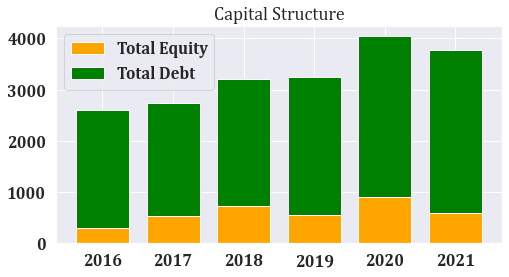

In [42]:
plt.figure(figsize=(8,4))
rc('font', weight = 'bold')
bars2 = BS['Total Debt']
bars1 = BS['Total Equity']

bars = np.add(bars1, bars2).tolist()

r = range(len(bars1))
 
names = BS.index.year
barWidth = 0.75

plt.bar(r, bars1, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')

plt.xticks(r, names, fontweight='bold')
plt.title("Capital Structure")
plt.legend()
plt.show()

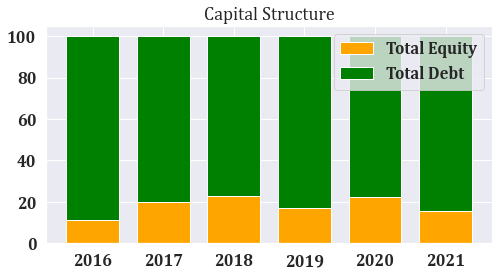

In [46]:
plt.figure(figsize=(8,4))
# Data
# r = []
raw_data = {'greenBars': BS['Total Debt'], 'orangeBars': BS['Total Equity']}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.75
# names = ()
# Create orange Bars (Equity)
plt.bar(r, orangeBars, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
# Create green Bars (Debt)
plt.bar(r, greenBars, bottom=orangeBars, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')
 
# Custom x axis
plt.xticks(r, names)
plt.title('Capital Structure')
 
# Show graphic
plt.legend(loc = 'upper right')
plt.show()


# Calculating the Fundamentals

In [88]:
Chg_WC = CF['Change in Net Working Capital']
eff_tax = IS['Effective Tax Rate %'].replace('NM' , 0)
capex = abs(CF['Capital Expenditure'])
depreciation = CF['Depreciation & Amort., Total']
EBIT = IS['EBIT']
after_tax_EBIT = EBIT * (1 - eff_tax)
Reinv_rate = (capex - depreciation + Chg_WC) / (EBIT * (1 - eff_tax))
roc = (IS['EBIT'] * (1 - eff_tax)) / (BS['Total Debt'] + BS['Total Equity'])
g = Reinv_rate * roc
fundamentals = pd.DataFrame(data = [Chg_WC, eff_tax, capex, depreciation, EBIT, after_tax_EBIT,
                                        Reinv_rate, roc, g],
                                index= [ 'Change in Working Capital',
                                        'Effective Tax Rate', 'Capex', 'Depreciation', 'EBIT','EBIT (1-t)',
                                        'Reinvestment Rate', 'ROC', 'g']).T

fundamentals


,Change in Working Capital,Effective Tax Rate,Capex,Depreciation,EBIT,EBIT (1-t),Reinvestment Rate,ROC,g
Date,,,,,,,,,
2016-06-30,12.0,0.340793,172.0,149.0,1051.0,692.826557,0.050518,0.265553,0.013415
2017-06-30,42.0,0.319457,231.0,148.0,1109.0,754.722187,0.165624,0.275748,0.045670
2018-06-30,88.0,0.219165,194.0,155.0,1125.0,878.439375,0.144575,0.273742,0.039576
2019-06-30,-29.0,0.199218,206.0,172.0,1104.0,884.063328,0.005656,0.272691,0.001542
2020-06-30,-353.0,0.207594,254.0,175.0,1251.0,991.299906,-0.276405,0.245129,-0.067755
2021-06-30,43.0,0.201111,331.0,205.0,1218.0,973.046802,0.173681,0.257556,0.044733


# Running the Simulation

In [89]:
t_intervals = 10
iterations = 100000

In [99]:
values = []
for i in range(iterations):
    Expected_g = np.random.normal(np.mean(fundamentals['g']), np.std(fundamentals['g']), size = t_intervals)
    WACC = 0.043986
    simWACC = np.random.normal(WACC, 0.01246298, size= t_intervals)
    Reinvestment_rate = np.random.normal(np.mean(fundamentals['Reinvestment Rate']), np.std(fundamentals['Reinvestment Rate']), size = t_intervals)
    tax = np.random.normal(np.mean(fundamentals['Effective Tax Rate']), np.std(fundamentals['Effective Tax Rate']), size = t_intervals)
    change_in_working_capital = np.random.normal(np.mean(fundamentals['Change in Working Capital']), np.std(fundamentals['Change in Working Capital']), size = t_intervals)

    Terminal_g = 0.015


    EBIT_E = []
    a = EBIT[-1]
    for i in range(t_intervals):
        a *= (1 + Expected_g[i])
        EBIT_E.append(a)

    after_tax_EBIT = (EBIT_E * (1 - tax))

    Capex_Dep = (after_tax_EBIT * Reinvestment_rate) - change_in_working_capital

    FCFF = after_tax_EBIT - change_in_working_capital - Capex_Dep

    discount_factor = []
    for i in range(t_intervals):
        if i == 0:
            i = 1 + simWACC[i]
            discount_factor.append(i)
        else:
            i = (1 + simWACC[i]) ** i
            discount_factor.append(i)

    PV = FCFF / discount_factor
    terminalValue = (FCFF[-1] * (1 + Terminal_g)) / (WACC - Terminal_g)
    PV_tV = terminalValue / ((1 + WACC) ** t_intervals)
    equityValue = PV.sum() + PV_tV - BS['Net Debt'][-1]
    sharesOutstanding = IS['Weighted Avg. Diluted Shares Out.'][-1]
    v = equityValue / sharesOutstanding
    values.append(v)



In [141]:
stock = round(yf.download(['CLX'], start = '2021-10-5')['Adj Close'][-1], 2)
stock


[*********************100%***********************]  1 of 1 completed


165.21

<ipython-input-142-b628f09d162c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)


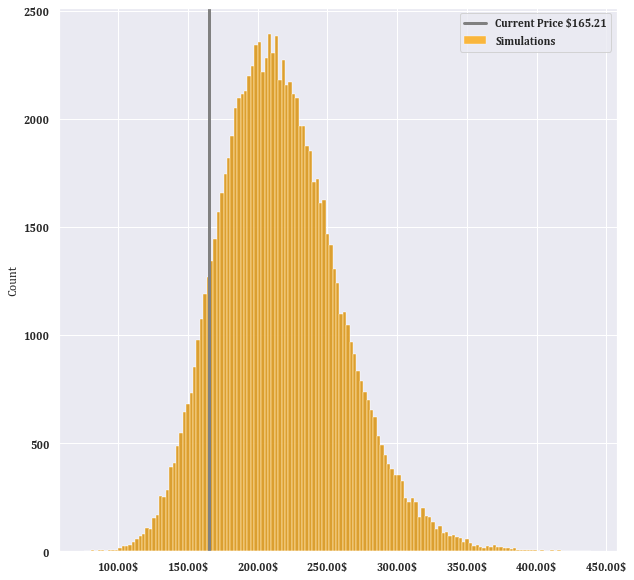

In [142]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale = 1, font = 'Cambria')
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.histplot(values).get_xticks()]
sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)
plt.legend()
plt.show()

<ipython-input-143-e145b4dd8226>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.ecdfplot(x=values, color = 'purple', label = 'Simulation CDF', linewidth = 2).set_xticklabels(xlabels)


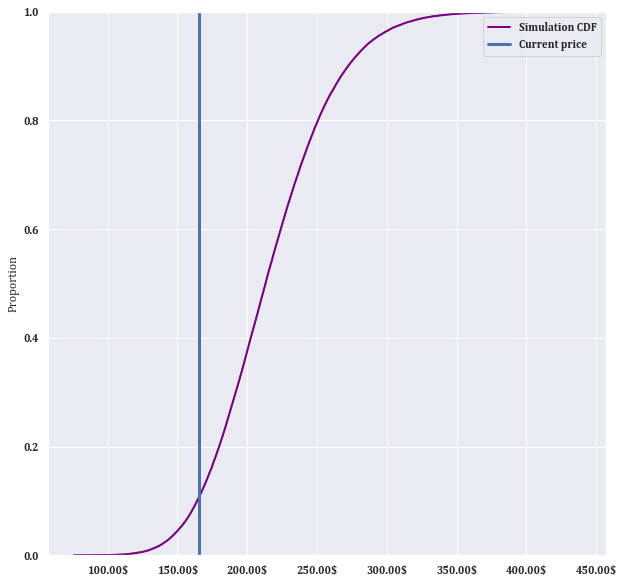

In [143]:
xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.ecdfplot(x=values).get_xticks()]
sns.ecdfplot(x=values, color = 'purple', label = 'Simulation CDF', linewidth = 2).set_xticklabels(xlabels)
plt.axvline(x=stock, ymin=0,ymax=1, label = 'Current price', linewidth = 3)
plt.legend()
plt.show()

In [144]:
Percentile_table = pd.DataFrame(data = [np.percentile(values, 0), np.percentile(values, 10), np.percentile(values, 20),
                                       np.percentile(values, 30), np.percentile(values, 40), np.percentile(values, 50),
                                       np.percentile(values, 60), np.percentile(values, 70), np.percentile(values, 80),
                                       np.percentile(values, 90), np.percentile(values, 100)],
                               index = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                               columns = ['Values'])

Percentile_table.index.name = 'Percentiles'
Percentile_table

,Values
Percentiles,
0%,75.708827
10%,164.097551
20%,179.898136
30%,191.767558
40%,202.529466
50%,213.121119
60%,224.074771
70%,236.209004
80%,250.727890


In [137]:
np.mean(values)

216.2151536414487

In [103]:
fcf_table = pd.DataFrame(data = [Reinvestment_rate, Expected_g, tax,
                                 EBIT_E, after_tax_EBIT, change_in_working_capital,
                                 Capex_Dep, FCFF, discount_factor,PV],
                         index = ['Reinvestment Rate', 'Expected Growth',
                                   'Tax','EBIT','EBIT(1-t)',
                                  'Change in Working Capital', 'Capex - Depreciation',
                                  'FCFF', 'Discount Factor','PV']).T
fcf_table

,Reinvestment Rate,Expected Growth,Tax,EBIT,EBIT(1-t),Change in Working Capital,Capex - Depreciation,FCFF,Discount Factor,PV
0,-0.006755,-0.048967,0.244968,1158.358034,874.597401,45.317912,-51.225691,880.505179,1.033505,851.959972
1,-0.075828,0.003406,0.360098,1162.303023,743.759783,-131.311240,74.913589,800.157434,1.041538,768.246147
2,-0.131780,0.009409,0.230313,1173.239230,903.027477,-102.051180,-16.950194,1022.028851,1.073624,951.942998
3,-0.284223,0.072243,0.214593,1257.997058,988.039235,28.789319,-309.612432,1268.862348,1.100732,1152.744242
4,0.064387,0.025361,0.326284,1289.901113,869.026774,6.954110,48.999842,813.072823,1.239189,656.133090
5,-0.006831,0.060678,0.337648,1368.169241,906.208960,-280.785770,274.595026,912.399705,1.243623,733.662550
6,0.024333,0.070671,0.244925,1464.859214,1106.078091,37.960809,-11.046669,1079.163950,1.204743,895.762730
7,0.065873,-0.036886,0.264691,1410.826718,1037.393352,-298.538973,366.875145,969.057180,1.361418,711.800009
8,0.153758,0.008241,0.213185,1422.453873,1119.208285,-82.169815,254.257144,947.120956,1.332899,710.572149
9,-0.067147,-0.052878,0.262619,1347.238005,993.428037,148.469034,-215.174714,1060.133718,1.598954,663.017062


In [97]:
tickers = ['CLX']
s = yf.download(tickers, start = '2009-03-31')
s = s['Adj Close']
returns = s.pct_change()
stats = pd.DataFrame(data = [returns.mean() * 252, returns.std() * (252 ** 0.5)],
             index = ['Mean', 'StDev'], columns= tickers)
stats

[*********************100%***********************]  1 of 1 completed


,CLX
Mean,0.141073
StDev,0.193154


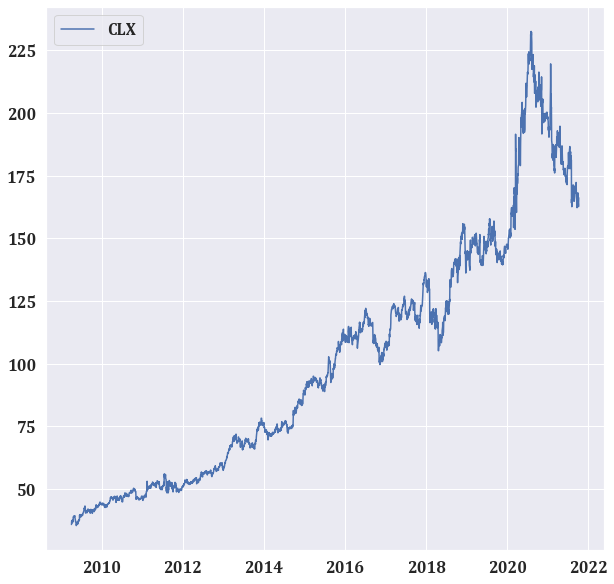

In [98]:
plt.plot(s, label = 'CLX')
plt.legend()